In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import random
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, accuracy_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2024-08-22 00:17:19.478731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Portfolio Optimization and Visualization

The code below performs a simulation to optimize a portfolio consisting of multiple stock's. It involves downloading historical adjusted close prices for the selected tickers, calculating daily and annual returns, volatility, and the covariance matrix. A large number of portfolios (100,000) are generated with random weights for each asset to explore different combinations.

The simulation computes the returns, volatility, and Sharpe ratio for each portfolio and visualizes the results on an Efficient Frontier plot. This plot shows the trade-off between risk (volatility) and return, with the color indicating the Sharpe ratio. The optimal portfolios are highlighted: the portfolio with the maximum Sharpe ratio (best risk-adjusted return), the portfolio with the minimum volatility, and the one with the maximum return. This visualization helps in selecting an optimal mix of the stock's to achieve desired investment goals while managing risk.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<Figure size 1000x800 with 0 Axes>

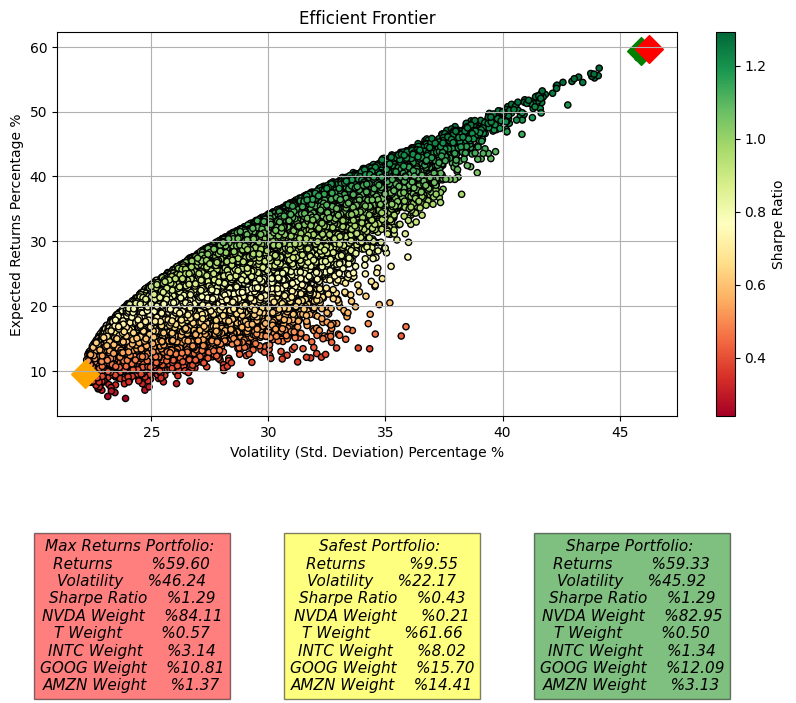

In [43]:
# Define parameters
selected = ["NVDA", "T", "INTC", "GOOG", "AMZN"]
start_year = '2018-01-01'
end_year = '2024-01-01'
Num_porSimulation = 100000  # Number of Portfolios to simulate

# Download stock data
frame = {}
for stock in selected:
    data_var = yf.download(stock, start=start_year, end=end_year)['Adj Close']
    frame[stock] = data_var

# Create DataFrame and calculate returns and volatility
table = pd.DataFrame(frame)
returns_daily = table.pct_change()
returns_annual = ((1 + returns_daily.mean())**250) - 1
std_daily = returns_daily.std()
std_annual = std_daily * (250**0.5)
Sharpe = (returns_annual - 0.04) / std_annual

# Calculate covariance
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# Initialize lists to store portfolio metrics
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# Set random seed for reproducibility
np.random.seed(42)

# Simulate portfolios
num_assets = len(selected)
num_portfolios = Num_porSimulation
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns * 100)
    port_volatility.append(volatility * 100)
    stock_weights.append(weights)

# Create DataFrame with portfolio metrics
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Extend DataFrame with weights for each ticker
for counter, symbol in enumerate(selected):
    portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]

df = pd.DataFrame(portfolio)

# Reorder DataFrame columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected]
df = df[column_order]

# Find min Volatility & max Sharpe values in the DataFrame (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_return = df['Returns'].max()
max_vol = df['Volatility'].max()

# Locate optimal portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_returns = df.loc[df['Returns'] == max_return]
max_vols = df.loc[df['Volatility'] == max_vol]

# Plot efficient frontier
plt.figure(figsize=(10, 8))
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black',figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='green', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='orange', marker='D', s=200)
plt.scatter(x=max_vols['Volatility'], y=max_returns['Returns'], c='red', marker='D', s=200)
plt.xlabel('Volatility (Std. Deviation) Percentage %')
plt.ylabel('Expected Returns Percentage %')
plt.title('Efficient Frontier')
plt.subplots_adjust(bottom=0.4)

# Add text annotations for optimal portfolios
red_num = df.index[df["Returns"] == max_return]
yellow_num = df.index[df['Volatility'] == min_volatility]
green_num = df.index[df['Sharpe Ratio'] == max_sharpe]
multseries = pd.Series([1, 1, 1] + [100 for stock in selected], index=['Returns', 'Volatility', 'Sharpe Ratio'] + [stock + ' Weight' for stock in selected])

with pd.option_context('display.float_format', '%{:,.2f}'.format):
    plt.figtext(0.2, 0.15, "Max Returns Portfolio: \n" + df.loc[red_num[0]].multiply(multseries).to_string(), bbox=dict(facecolor='red', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center', wrap=True)
    plt.figtext(0.45, 0.15, "Safest Portfolio: \n" + df.loc[yellow_num[0]].multiply(multseries).to_string(), bbox=dict(facecolor='yellow', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center', wrap=True)
    plt.figtext(0.7, 0.15, "Sharpe Portfolio: \n" + df.loc[green_num[0]].multiply(multseries).to_string(), bbox=dict(facecolor='green', alpha=0.5), fontsize=11, style='oblique', ha='center', va='center', wrap=True)
plt.show()


### Downloading NVDA and GOOG Stocks Data from Yahoo Finance

In this step, we use the `yfinance` library to download historical data for the NVDA and GOOG stocks, covering the period from January 1, 2018, to January 1, 2024. 

The dataset includes key metrics such as:
- Open
- High
- Low
- Close
- Adjusted Close
- Volume

We also add a name attribute to the DataFrame for labeling purposes, which helps in identifying the dataset in future analyses. Below, we display the first few rows of the dataset to get an overview of the data.


In [49]:
# Download QQQ data
nvda = yf.download("NVDA", start="2018-01-01", end="2024-01-01")

# Add a name attribute to the DataFrame for labeling
nvda.name = "NVDA"

# Display first few rows of the dataset
nvda.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,4.89450,4.98750,4.86250,4.98375,4.930643,355616000
2018-01-03,5.10250,5.34250,5.09375,5.31175,5.255147,914704000
2018-01-04,5.39400,5.45125,5.31725,5.33975,5.282848,583268000
2018-01-05,5.35475,5.42275,5.27700,5.38500,5.327616,580124000
2018-01-08,5.51000,5.62500,5.46450,5.55000,5.490858,881216000


In [50]:
# Download QQQ data
goog = yf.download("GOOG", start="2018-01-01", end="2024-01-01")

# Add a name attribute to the DataFrame for labeling
goog.name = "GOOG"

# Display first few rows of the dataset
goog.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.417000,53.347000,52.261501,53.250000,53.189472,24752000
2018-01-03,53.215500,54.314499,53.160500,54.124001,54.062481,28604000
2018-01-04,54.400002,54.678501,54.200100,54.320000,54.258255,20092000
2018-01-05,54.700001,55.212502,54.599998,55.111500,55.048855,25582000
2018-01-08,55.111500,55.563499,55.081001,55.347000,55.284088,20952000


### Distribution Plot for Stocks

This plot represents the distribution of daily returns for the NVDA and GOOG stocks from January 1, 2018, to January 1, 2024. We use a Kernel Density Estimate (KDE) to visualize the probability distribution of returns, which helps in understanding the overall shape and spread of the returns distribution.

Vertical dashed lines are plotted for the 5% and 95% quantiles. These quantiles indicate the threshold values below which 5% of the returns lie and above which 95% of the returns lie. They are useful for identifying extreme movements and assessing the range of return values.

#### Summary Statistics:
- **Median**: The middle value of the returns distribution, representing the central tendency of the returns.
- **Min/Max**: The lowest and highest daily returns, showing the range of return values.
- **Mean**: The average return over the period, providing an overall sense of return performance.
- **5% Quantile**: The return value below which 5% of the data falls, indicating lower extreme returns.
- **50% Quantile (Median)**: The same as the median, confirming the central value.
- **95% Quantile**: The return value above which 5% of the data falls, indicating higher extreme returns.


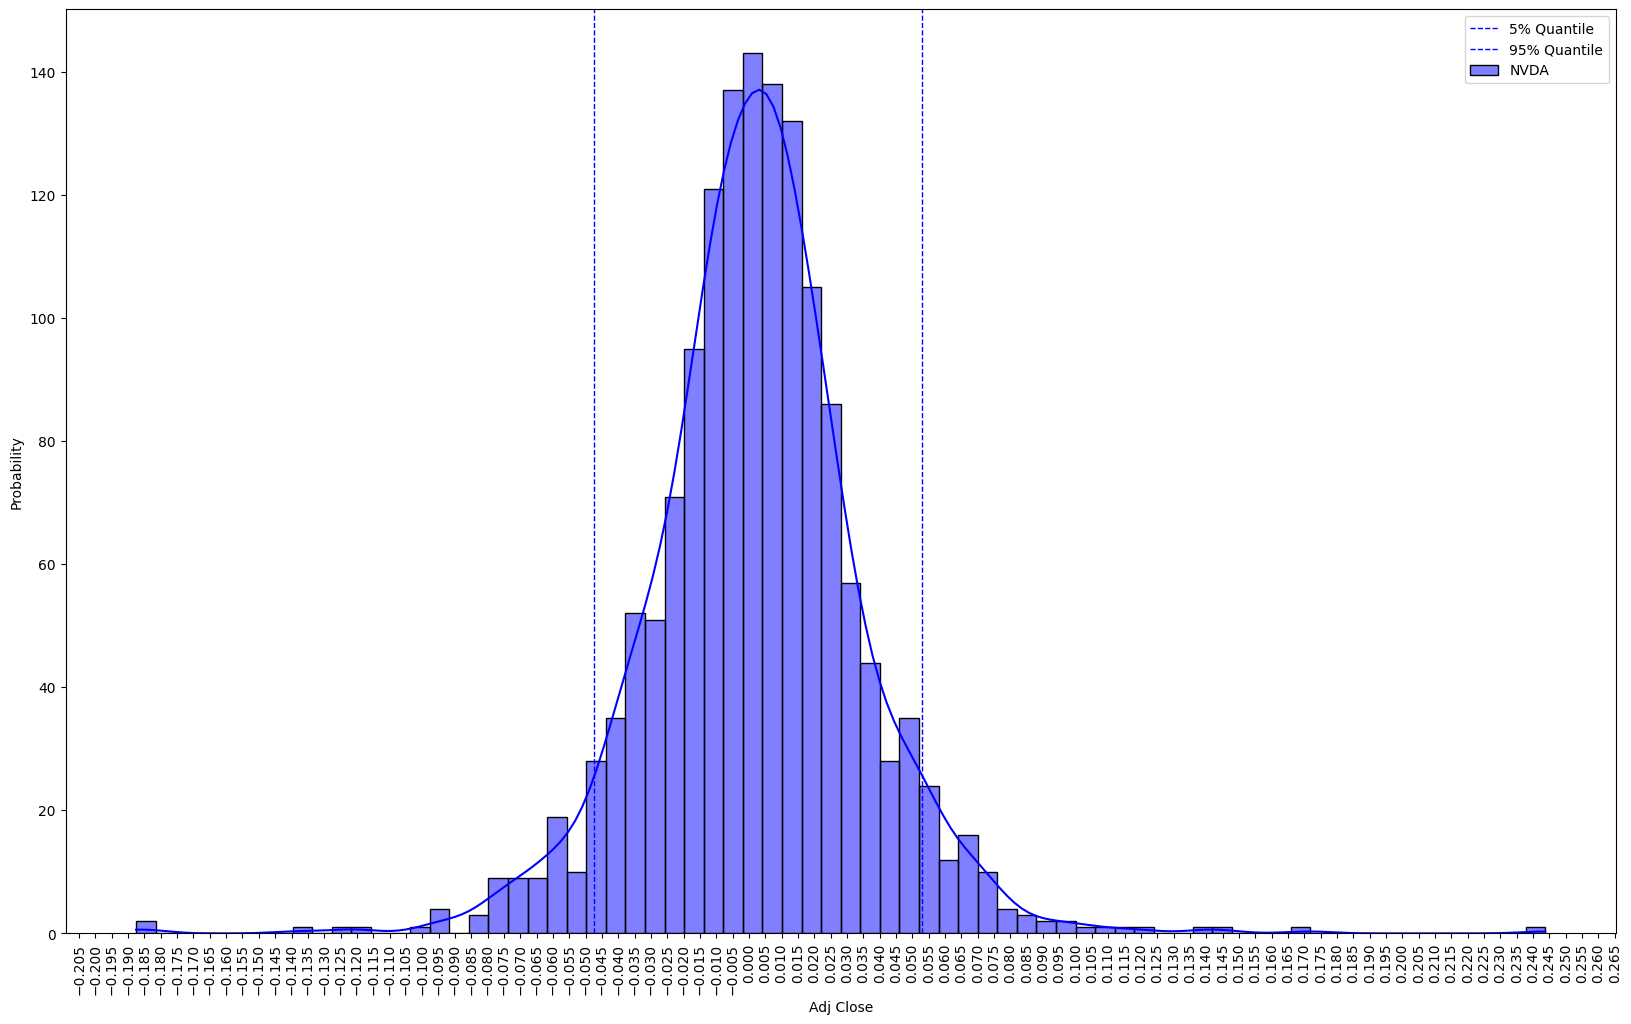

     Median       Min       Max      Mean  5% Quantile  50% Quantile  \
0  0.002633 -0.187559  0.243696  0.002054     -0.04734      0.002633   

   95% Quantile  
0      0.052921  


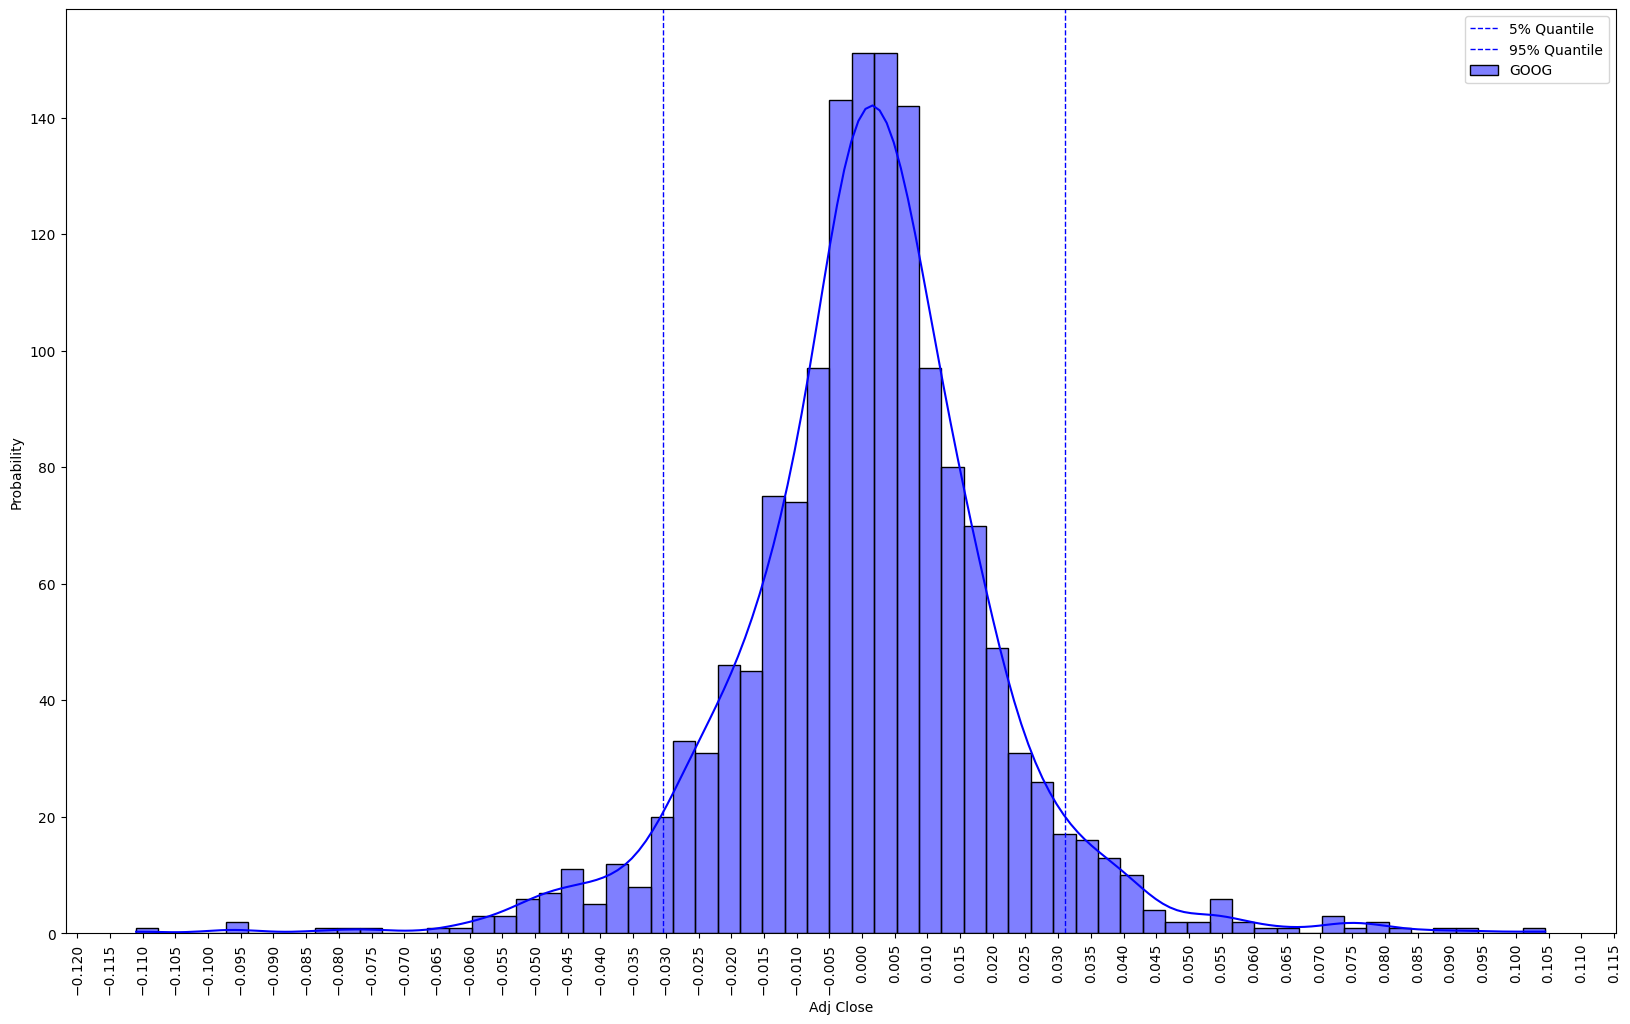

     Median       Min       Max      Mean  5% Quantile  50% Quantile  \
0  0.001072 -0.111008  0.104485  0.000839    -0.030362      0.001072   

   95% Quantile  
0      0.031037  


In [51]:
def analyze_ticker_distribution(data):
    # Calculate daily returns
    returns = data['Adj Close'].pct_change().dropna()
    
    # Set the size of the figure
    plt.figure(figsize=(20, 12))
    
    # Create a distribution plot with Kernel Density Estimate (KDE)
    sns.histplot(returns, kde=True, label=data.name, color='blue')
    
    # Calculate and plot the ±5% and 95% quantiles
    threshold_5_percent = returns.quantile(0.05)
    threshold_95_percent = returns.quantile(0.95)
    
    # Add vertical dashed lines for quantiles
    plt.axvline(threshold_5_percent, color='blue', linestyle='dashed', linewidth=1, label='5% Quantile')
    plt.axvline(threshold_95_percent, color='blue', linestyle='dashed', linewidth=1, label='95% Quantile')
    
    # Customize x-axis labels and ticks
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(MultipleLocator(0.005))
    
    # Set y-axis label and display legend
    plt.ylabel('Probability')
    plt.legend()
    
    # Show the plot
    plt.show()
    
    # Calculate and display summary statistics
    summary_stats = {
        'Median': returns.median(),
        'Min': returns.min(),
        'Max': returns.max(),
        'Mean': returns.mean(),
        '5% Quantile': threshold_5_percent,
        '50% Quantile': returns.quantile(0.50),
        '95% Quantile': threshold_95_percent
    }
    
    # Convert dictionary to DataFrame for better display
    summary_stats_df = pd.DataFrame([summary_stats])
    
    return summary_stats_df

# Example call using preloaded data
summary_stats_df_nvda = analyze_ticker_distribution(nvda)
print(summary_stats_df_nvda)

# Example call using preloaded data
summary_stats_df_goog = analyze_ticker_distribution(goog)
print(summary_stats_df_goog)

### Bollinger Bands for NVDA and GOOG

This plot displays the Bollinger Bands for the NVDA and GOOG from January 1, 2018, to January 1, 2024. Bollinger Bands are a technical analysis tool used to measure the volatility and identify potential buy or sell signals.

#### Components:
- **Price**: The adjusted closing price of NVDA and GOOG.
- **30-Day Moving Average**: The rolling average of the price over a 30-day window, representing the central tendency of the price movement.
- **Upper Band**: The upper boundary of the Bollinger Bands, calculated as the 30-day moving average plus 1.5 times the rolling standard deviation. It indicates the level above which the price is considered high.
- **Lower Band**: The lower boundary of the Bollinger Bands, calculated as the 30-day moving average minus 1.5 times the rolling standard deviation. It indicates the level below which the price is considered low.

#### Trading Signals:
- **Buy Signal**: When the price falls below the lower band, it may signal a buying opportunity. This is highlighted with red markers on the plot.
- **Sell Signal**: When the price rises above the moving average after a buy signal, it may indicate a selling opportunity. This is highlighted with green markers on the plot.

#### Profit Calculation:
- The profit is calculated based on hypothetical trading strategies where stocks are bought when the price crosses below the lower band and sold when it crosses above the moving average.
- The profit percentage reflects the performance of this strategy over the given period.

This analysis helps in understanding how NVDA and GOOG's price volatility behaves relative to its historical averages and can aid in making informed trading decisions.


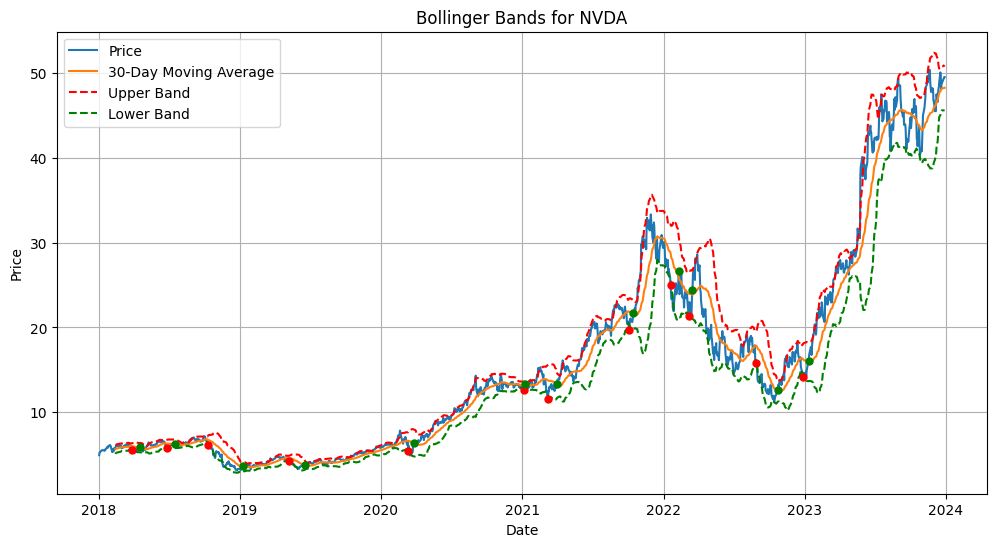

Total profit earned in dollars: 67.32231616973877
Total profit earned in percentage: 3.975219151122711 %


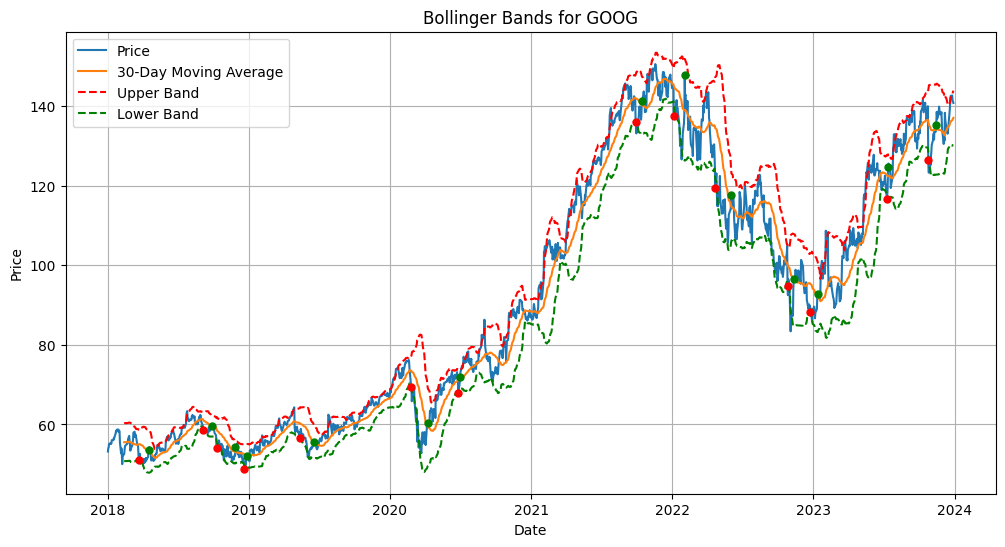

Total profit earned in dollars: 380.9465789794922
Total profit earned in percentage: 2.1505829976099364 %


In [53]:
def calculate_bollinger_bands(df, window_size=30, num_std=2):
    """
    Calculate Bollinger Bands.
    
    Parameters:
    - df: DataFrame with 'Adj Close' column.
    - window_size: Number of days for the moving average.
    - num_std: Number of standard deviations for the bands.
    
    Returns:
    - rolling_mean: Series of rolling mean.
    - upper_band: Series of upper Bollinger Band.
    - lower_band: Series of lower Bollinger Band.
    """
    rolling_mean = df['Adj Close'].rolling(window=window_size).mean()
    rolling_std = df['Adj Close'].rolling(window=window_size).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return rolling_mean, upper_band, lower_band

def plot_bollinger_bands(df, window_size=30, num_std=2):
    """
    Plot Bollinger Bands and buy/sell signals.
    
    Parameters:
    - df: DataFrame with 'Adj Close' column and Bollinger Bands.
    
    Returns:
    - profit: Total profit in dollars.
    - profit_percentage: Total profit as a percentage.
    """
    # Calculate Bollinger Bands
    df['RollingMean'], df['UpperBand'], df['LowerBand'] = calculate_bollinger_bands(df, window_size, num_std)
    
    # Initialize variables for tracking profit and buy/sell signals
    bought_stock = False
    buy_price = 0
    profit = 0
    num_buy = 0
    
    # Plotting Bollinger Bands and stock price
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Adj Close'], label='Price')
    plt.plot(df.index, df['RollingMean'], label=f'{window_size}-Day Moving Average')
    plt.plot(df.index, df['UpperBand'], 'r--', label='Upper Band')
    plt.plot(df.index, df['LowerBand'], 'g--', label='Lower Band')
    
    # Identify Buy and Sell points based on Bollinger Bands
    for i in range(1, len(df)):
        if df['Adj Close'].iloc[i] < df['LowerBand'].iloc[i] and not bought_stock:
            plt.plot(df.index[i], df['Adj Close'].iloc[i], 'ro', markersize=5)  # Mark buy point
            bought_stock = True
            buy_price = df['Adj Close'].iloc[i]
            num_buy += 1
        elif df['Adj Close'].iloc[i] > df['RollingMean'].iloc[i] and bought_stock:
            plt.plot(df.index[i], df['Adj Close'].iloc[i], 'go', markersize=5)  # Mark sell point
            profit += (df['Adj Close'].iloc[i] - buy_price) * 10  # Assuming 10 shares per trade
            bought_stock = False
    
    # Use the name attribute for the title
    plt.title(f'Bollinger Bands for {df.name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate profit in percentages
    initial_investment = buy_price * 10 * num_buy if num_buy > 0 else 1  # Avoid division by zero
    total_return = profit + initial_investment
    profit_percentage = (total_return - initial_investment) / initial_investment * 100
    
    return profit, profit_percentage


total_profit_nvda, profit_percentage_nvda = plot_bollinger_bands(nvda)
print("Total profit earned in dollars:", total_profit_nvda)
print("Total profit earned in percentage:", profit_percentage_nvda, "%")

total_profit_goog, profit_percentage_goog = plot_bollinger_bands(goog)
print("Total profit earned in dollars:", total_profit_goog)
print("Total profit earned in percentage:", profit_percentage_goog, "%")


### Moving Average Strategy for NVDA and GOOG

This plot illustrates the Moving Average (MA) trading strategy for NVDA and GOOG from January 1, 2018, to January 1, 2024. Moving averages are used to smooth out price fluctuations and identify potential trading signals.

#### Components:
- **Price**: The adjusted closing price of NVDA and GOOG, shown as a faint line.
- **12-Day Moving Average**: The short-term moving average, represented by the orange line, which reacts more quickly to recent price changes.
- **26-Day Moving Average**: The long-term moving average, represented by the blue line, which smooths out longer-term price trends.

#### Trading Signals:
- **Buy Signal**: Indicated by green triangles, these signals occur when the 12-day moving average crosses above the 26-day moving average. This suggests a potential uptrend and an opportunity to buy.
- **Sell Signal**: Shown with red triangles, these signals appear when the 12-day moving average crosses below the 26-day moving average, indicating a potential downtrend and an opportunity to sell.

#### Profit Calculation:
- The profit is calculated based on a hypothetical trading strategy where positions are taken when buy signals occur and exited when sell signals are generated.

This analysis demonstrates how the moving average crossover strategy can be used to identify trading opportunities based on price trends and evaluates the effectiveness of trend-following strategies in capturing profitable movements.


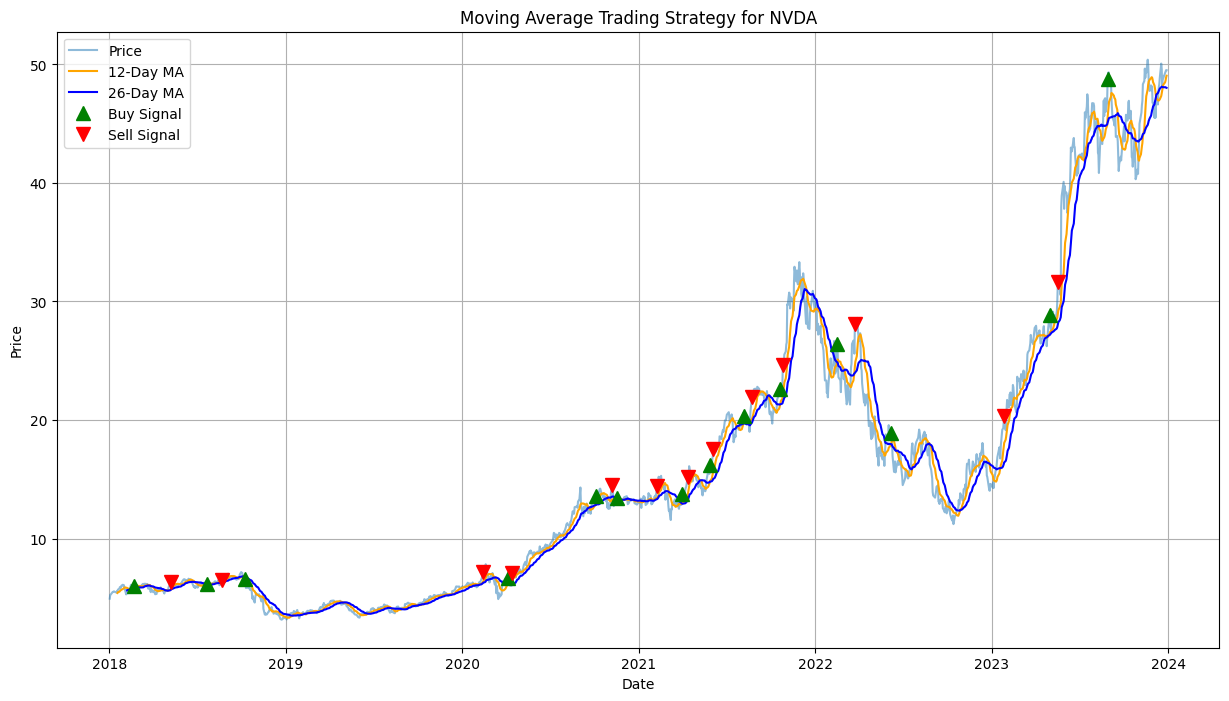

Total Profit in Long Positions: 99.31%


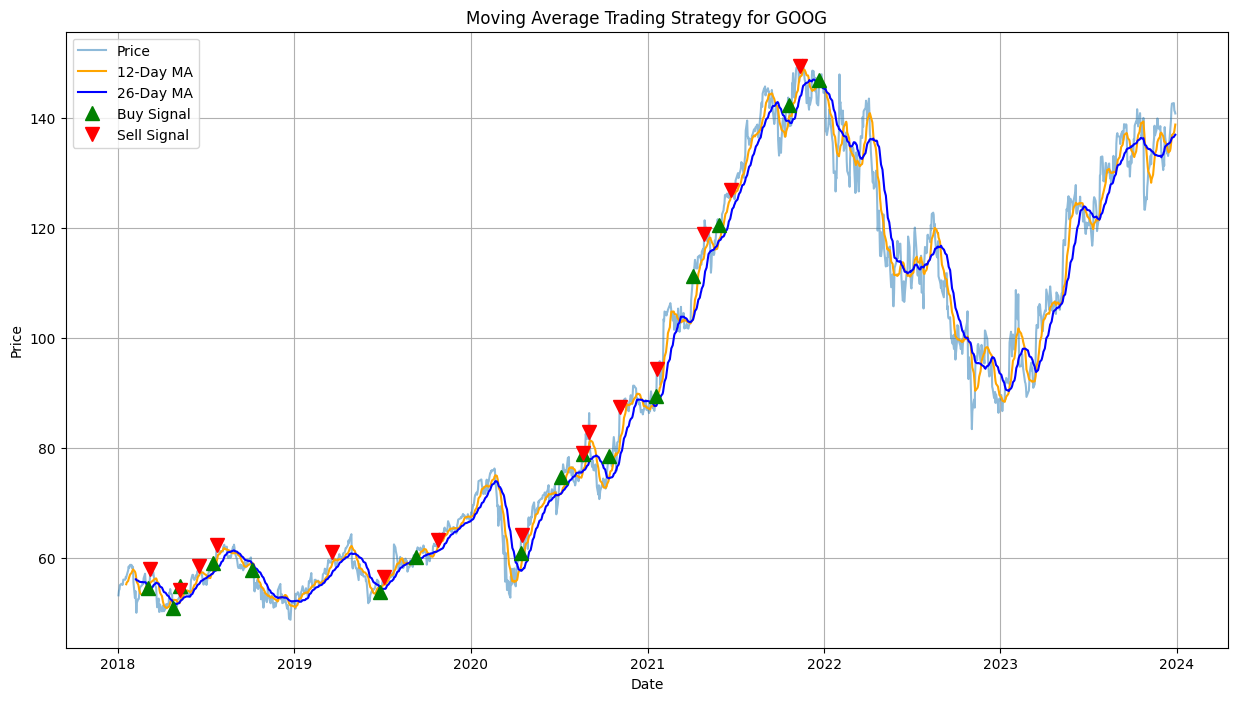

Total Profit in Long Positions: 91.01%


In [146]:
def moving_average(df, short_window=12, long_window=26):
    """
    Apply a moving average strategy with buy/sell signals.
    
    Parameters:
    - df: DataFrame with 'Adj Close' column.
    - short_window: Window size for short-term moving average.
    - long_window: Window size for long-term moving average.
    
    Returns:
    - total_profit: Total profit as a percentage.
    """
    # Calculate short-term and long-term moving averages
    df['Short_MA'] = df['Adj Close'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Adj Close'].rolling(window=long_window).mean()

    # Initialize signals
    df['Signal'] = 0  # 0: No Signal, 1: Buy Signal, -1: Sell Signal
    holding_position = 0  # 0: No Position, 1: Long Position
    entry_price = 0  # Entry price for long position
    total_profit = 0  # Track total profit

    # Generate buy and sell signals based on moving averages
    for i in range(1, len(df)):
        if holding_position == 0:
            if df['Short_MA'].iloc[i] > df['Long_MA'].iloc[i] and df['Short_MA'].iloc[i-1] < df['Long_MA'].iloc[i-1]:
                df.loc[df.index[i], 'Signal'] = 1  # Buy Signal
                holding_position = 1
                entry_price = df['Adj Close'].iloc[i]
        if holding_position == 1:
            if df['Adj Close'].iloc[i] / entry_price > 1.05:  # Exit at 5% profit
                df.loc[df.index[i], 'Signal'] = -1  # Sell Signal
                holding_position = 0
                total_profit += (df['Adj Close'].iloc[i] / entry_price - 1)

    # Plotting the data and signals
    plt.figure(figsize=(15, 8))
    plt.plot(df.index, df['Adj Close'], label='Price', alpha=0.5)
    plt.plot(df.index, df['Short_MA'], label=f'{short_window}-Day MA', color='orange')
    plt.plot(df.index, df['Long_MA'], label=f'{long_window}-Day MA', color='blue')
    plt.plot(df[df['Signal'] == 1].index, df[df['Signal'] == 1]['Adj Close'], '^', markersize=10, color='g', label='Buy Signal')
    plt.plot(df[df['Signal'] == -1].index, df[df['Signal'] == -1]['Adj Close'], 'v', markersize=10, color='r', label='Sell Signal')
    plt.xlabel('Date')
    plt.ylabel('Price')
    
    # Dynamic title based on DataFrame's name attribute
    plt.title(f'Moving Average Trading Strategy for {df.name}')
    
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print total profit
    print(f"Total Profit in Long Positions: {total_profit:.2%}")

moving_average(nvda)
moving_average(goog)


### RSI Trading Strategy for NVDA and GOOG

This plot showcases the Relative Strength Index (RSI) trading strategy for the NVDA and GOOG from January 1, 2018, to January 1, 2024. The RSI is a momentum oscillator used to identify overbought or oversold conditions in a stock.

#### Components:
- **Price**: The adjusted closing price of NVDA and GOOG, depicted as a blue line.
- **RSI**: The RSI value, shown as an orange line, which oscillates between 0 and 100 and helps in identifying potential buy or sell signals.

#### Trading Signals:
- **Buy Signal**: Marked with red triangles, these signals are triggered when the RSI falls below 30 (indicating potential oversold conditions) and the volume is lower than the average volume over the past 14 days. This suggests a potential buying opportunity.
- **Sell Signal**: Indicated by green triangles, these signals occur when the RSI rises above 60 (indicating potential overbought conditions). This suggests a potential selling opportunity.

#### Profit Calculation:
- The total profit is calculated based on hypothetical trading scenarios where shares are bought when buy signals occur and sold when sell signals are generated.
- The total earnings are represented in both dollars and percentage terms, reflecting the effectiveness of this strategy over the given period.

This analysis provides insight into how the RSI can be used to make informed trading decisions based on momentum and market conditions, and it helps in understanding the performance of the strategy in capturing profitable trades.


Total earnings in dollars: 82.38094806671143
Total earnings in percentage: 167.07953641995348


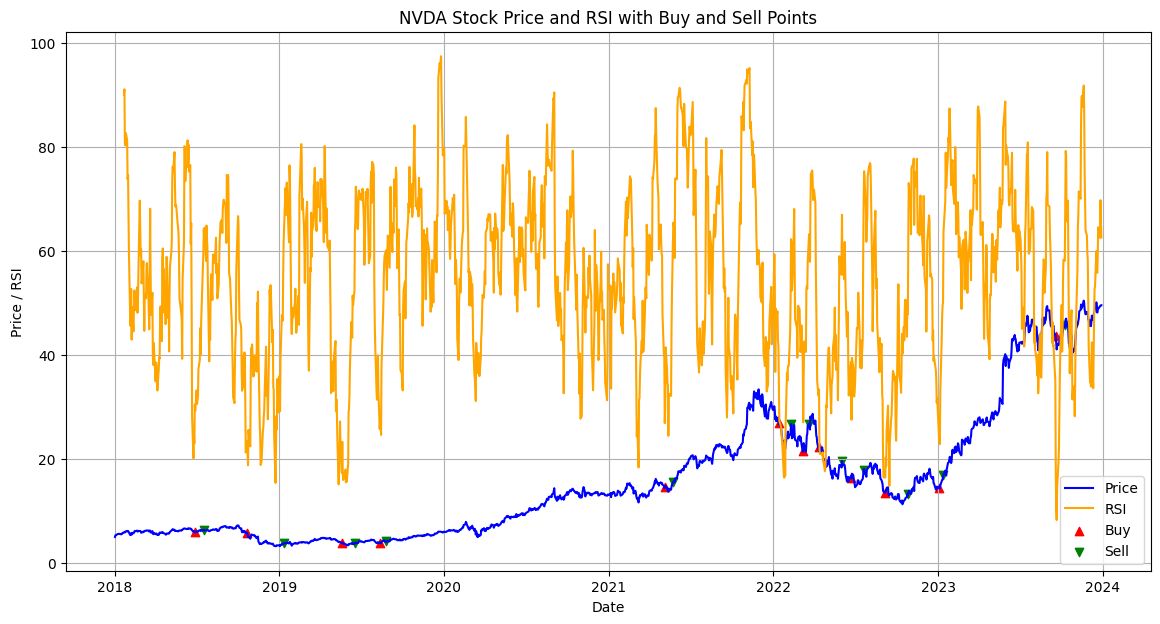

Total earnings in dollars: 309.88719940185547
Total earnings in percentage: 58.261002900245785


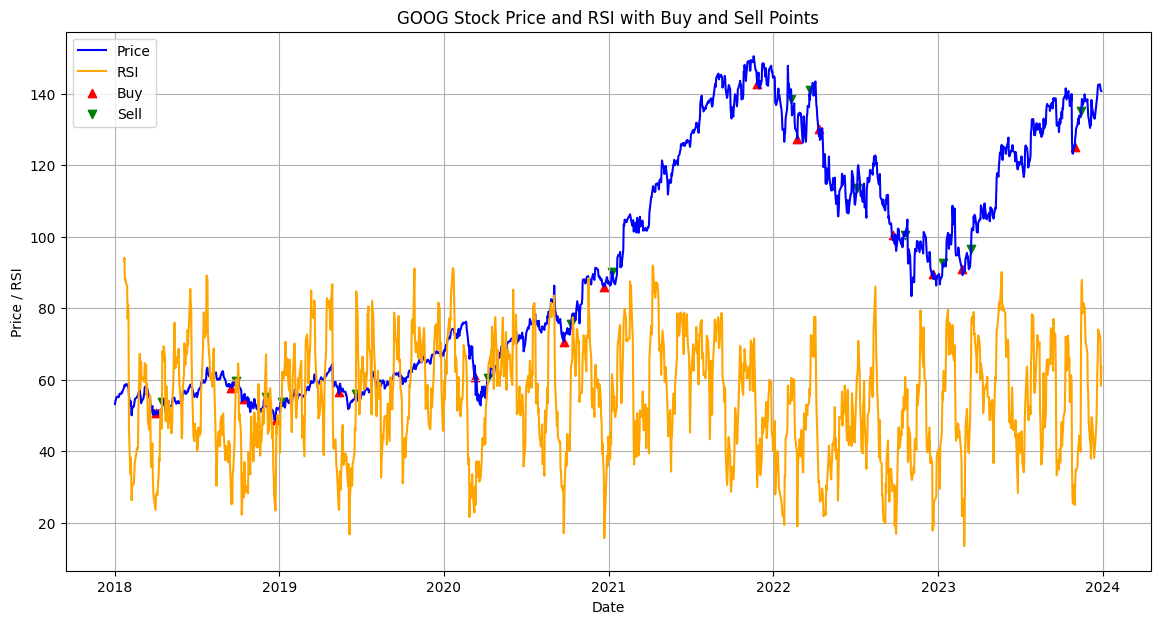

In [54]:
def calculate_rsi(data, window=14):
    """
    Calculate the Relative Strength Index (RSI).
    
    Parameters:
    - data: DataFrame with 'Adj Close' column.
    - window: Window size for RSI calculation.
    
    Returns:
    - RSI: Series containing the RSI values.
    """
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def rsi_strategy(df, buy_rsi_threshold=30, sell_rsi_threshold=60):
    """
    Implement a buy/sell strategy based on RSI and volume.
    
    Parameters:
    - df: DataFrame with 'Adj Close' and 'Volume' columns.
    - buy_rsi_threshold: RSI threshold to buy the stock.
    - sell_rsi_threshold: RSI threshold to sell the stock.
    
    Returns:
    - total_earnings_dollars: Total earnings in dollars.
    - total_earnings_percentage: Total earnings as a percentage.
    """
    # Calculate RSI and average volume
    df['RSI'] = calculate_rsi(df)
    df['Average Volume'] = df['Volume'].rolling(window=14).mean()

    # Initialize variables for strategy
    buy_price = None
    bought_shares = 0
    bought = False
    transactions = []
    earnings = []

    # Iterate over DataFrame and implement buy/sell strategy
    for index, row in df.iterrows():
        if row['RSI'] <= buy_rsi_threshold and row['Volume'] < row['Average Volume']:
            if not bought:
                buy_price = row['Adj Close']
                bought = True
                shares_to_buy = 10
                bought_shares += shares_to_buy
                transactions.append(('Buy', index, buy_price, shares_to_buy))
        elif row['RSI'] >= sell_rsi_threshold:
            if bought:
                sell_price = row['Adj Close']
                earnings.append((sell_price - buy_price) * bought_shares)
                bought_shares = 0
                transactions.append(('Sell', index, sell_price))
                bought = False

    # If bought and the end of data is reached, sell
    if bought:
        sell_price = df.iloc[-1]['Adj Close']
        earnings.append((sell_price - buy_price) * bought_shares)
        transactions.append(('Sell', df.index[-1], sell_price))

    # Calculate total earnings
    total_earnings_dollars = sum(earnings)
    total_earnings_percentage = (total_earnings_dollars / (df['Adj Close'].iloc[0] * 10)) * 100

    # Print total earnings
    print("Total earnings in dollars:", total_earnings_dollars)
    print("Total earnings in percentage:", total_earnings_percentage)

    # Plot the data, RSI, and transactions
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Adj Close'], label='Price', color='blue')
    plt.plot(df.index, df['RSI'], label='RSI', color='orange')

    # Initialize flags for the labels
    buy_label_shown = False
    sell_label_shown = False

    for trans in transactions:
        if trans[0] == 'Buy':
            if not buy_label_shown:
                plt.scatter(trans[1], trans[2], color='red', marker='^', label='Buy')
                buy_label_shown = True  # Mark label as shown
            else:
                plt.scatter(trans[1], trans[2], color='red', marker='^')  # No label for subsequent points
        elif trans[0] == 'Sell':
            if not sell_label_shown:
                plt.scatter(trans[1], trans[2], color='green', marker='v', label='Sell')
                sell_label_shown = True  # Mark label as shown
            else:
                plt.scatter(trans[1], trans[2], color='green', marker='v')  # No label for subsequent points

    plt.title(f'{df.name} Stock Price and RSI with Buy and Sell Points')
    plt.xlabel('Date')
    plt.ylabel('Price / RSI')
    plt.legend()
    plt.grid(True)
    plt.show()

    return total_earnings_dollars, total_earnings_percentage

_ = rsi_strategy(nvda)
_ = rsi_strategy(goog)


### Logistic Regression Analysis on NVDA and GOOG with Economic Indicators

In this section, we perform a logistic regression analysis to predict whether the price of NVDA and GOOG will increase or decrease based on historical stock data combined with additional economic indicators. This approach aims to understand the impact of broader economic factors on stock price movements.

#### Feature Engineering:
1. **HLP (High-Low Percentage)**: The percentage difference between the high and low prices relative to the low price.
2. **GAP (Open-Close Percentage)**: The percentage difference between the closing and opening prices relative to the opening price.
3. **HC (High-Close Percentage)**: The percentage difference between the high and close prices relative to the close price.
4. **LC (Low-Close Percentage)**: The percentage difference between the low and close prices relative to the close price.
5. **VolumeChange**: The percentage change in trading volume from the previous day.

#### Additional Economic Indicators:
- **Tech Index (NASDAQ Composite Index)**: Represents the performance of the technology sector.
- **Finance Index (XLF ETF)**: Reflects the performance of the financial sector.
- **Europe Stock Index (VGK ETF)**: Captures the performance of European equities.
- **Russell 2000 Index**: Tracks the performance of small-cap companies in the U.S.

#### Data Cleaning and Feature Selection:
- **Noise Reduction**: Outliers are removed based on Z-scores to reduce noise in the data.
- **Feature Selection**: Features with high Variance Inflation Factor (VIF) are removed to prevent multicollinearity, ensuring a more robust model.

#### Model Training:
- **Logistic Regression**: A logistic regression model is trained to classify daily returns as either positive or negative based on the engineered features and economic indicators.
- **Training and Testing Split**: The data is split into training and testing sets to evaluate the model's performance.

#### Model Evaluation:
- **Accuracy**: The percentage of correct predictions made by the model.
- **Confusion Matrix**: A table that provides insight into the true positives, true negatives, false positives, and false negatives.
- **Classification Report**: Includes metrics like precision, recall, and F1-score.
- **ROC-AUC Score**: Evaluates the trade-off between true positive rate and false positive rate. A higher ROC-AUC score indicates better model performance.
- **ROC Curve**: A graphical representation of the model's performance across different classification thresholds.

This analysis provides valuable insights into how NVDA and GOOG stock prices respond to various economic factors and the effectiveness of logistic regression in predicting stock price movements.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Rows before cleaning: 1509, Rows after cleaning: 1390
Columns before VIF cleaning: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'HLP', 'GAP', 'HC', 'LC', 'VolumeChange', 'TechIndex', 'FinanceIndex', 'EuropeStockIndex', 'Russell2000']
Columns after VIF cleaning: ['GAP', 'VolumeChange', 'TechIndex', 'FinanceIndex', 'EuropeStockIndex', 'Russell2000']

Logistic Regression Accuracy: 0.8525

Confusion Matrix:
[[120  20]
 [ 21 117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       140
           1       0.85      0.85      0.85       138

    accuracy                           0.85       278
   macro avg       0.85      0.85      0.85       278
weighted avg       0.85      0.85      0.85       278


ROC-AUC Score: 0.9471


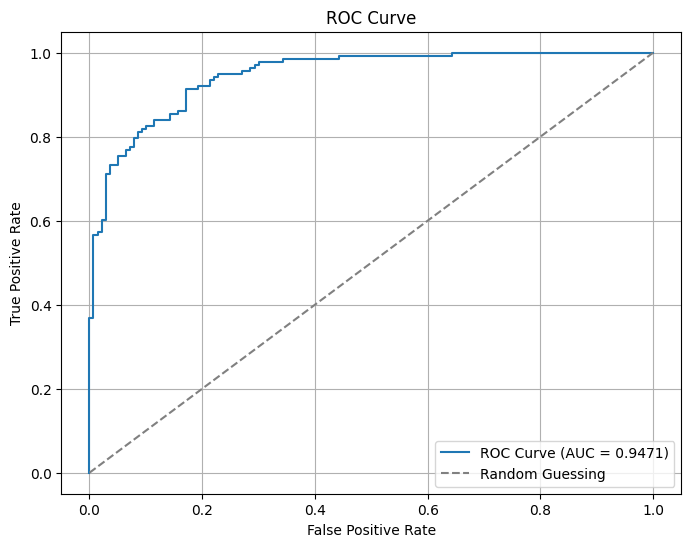


Rows before cleaning: 1509, Rows after cleaning: 1384
Columns before VIF cleaning: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'HLP', 'GAP', 'HC', 'LC', 'VolumeChange', 'TechIndex', 'FinanceIndex', 'EuropeStockIndex', 'Russell2000']
Columns after VIF cleaning: ['GAP', 'VolumeChange', 'TechIndex', 'FinanceIndex', 'EuropeStockIndex', 'Russell2000']

Logistic Regression Accuracy: 0.8664

Confusion Matrix:
[[114  22]
 [ 15 126]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       136
           1       0.85      0.89      0.87       141

    accuracy                           0.87       277
   macro avg       0.87      0.87      0.87       277
weighted avg       0.87      0.87      0.87       277


ROC-AUC Score: 0.9395


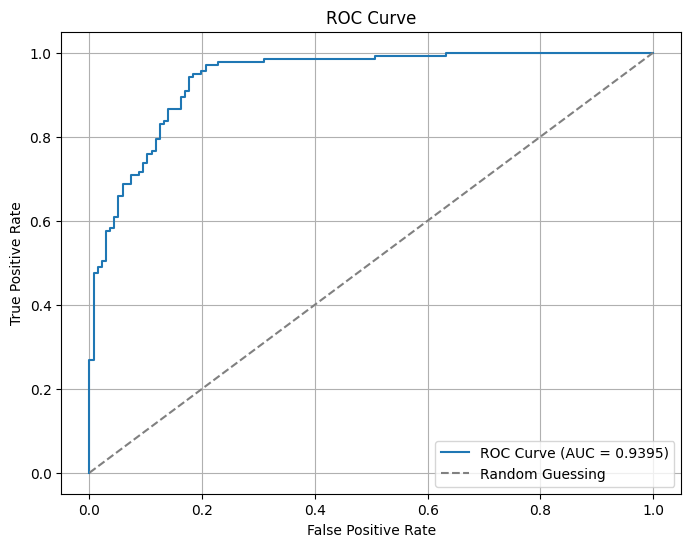

In [63]:
def clean_data_with_noise(ticker_df):
    """
    Clean the data by removing outliers based on Z-score.
    
    Parameters:
    - ticker_df: DataFrame containing stock data.
    
    Returns:
    - Cleaned DataFrame with reduced noise.
    """
    z_scores = np.abs((ticker_df - ticker_df.mean()) / ticker_df.std())
    cleaned_df = ticker_df[(z_scores < 3).all(axis=1)]  # Removing outliers with a Z-score above 3
    return cleaned_df

def remove_high_vif_features(df, threshold=8.0):
    """
    Remove features with a VIF higher than the specified threshold.
    
    Parameters:
    - df: DataFrame containing feature data.
    - threshold: VIF threshold for removing features.
    
    Returns:
    - DataFrame with features having VIF less than the threshold.
    """
    vif_data = pd.DataFrame()
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif_data["Feature"] = df.columns
    
    # Filter out features with VIF above the threshold
    low_vif_features = vif_data[vif_data["VIF"] < threshold]["Feature"]
    return df[low_vif_features]

def logistic_regression_analysis(ticker_df, additional_data):
    """
    Perform logistic regression analysis on stock data with additional explanatory variables.
    
    Parameters:
    - ticker_df: DataFrame containing stock data with columns 'High', 'Low', 'Open', 'Close', 'Volume', and 'Adj Close'.
    - additional_data: DataFrame containing additional explanatory variables (e.g., other indices, economic indicators).
    
    Returns:
    - None
    """

    # Feature Engineering on Stock Data
    ticker_df['HLP'] = (ticker_df['High'] - ticker_df['Low']) / ticker_df['Low'] * 100.0
    ticker_df['GAP'] = (ticker_df['Close'] - ticker_df['Open']) / ticker_df['Open'] * 100.0
    ticker_df['HC'] = (ticker_df['High'] - ticker_df['Close']) / ticker_df['Close'] * 100.0
    ticker_df['LC'] = (ticker_df['Low'] - ticker_df['Close']) / ticker_df['Close'] * 100.0
    ticker_df['VolumeChange'] = ticker_df['Volume'].pct_change()

    # Combine stock data with additional explanatory variables
    combined_df = pd.concat([ticker_df, additional_data], axis=1)

    # Record number of rows and columns before cleaning
    len_before = len(combined_df)
    cols_before_vif = combined_df.columns

    # Step 1: Clean the combined data for noise (remove outliers)
    combined_df = clean_data_with_noise(combined_df)

    # Record number of rows and columns after cleaning
    len_after = len(combined_df)

    # Step 2: Remove features with high VIF
    features = ['HLP', 'GAP', 'HC', 'LC', 'VolumeChange'] + list(additional_data.columns)
    combined_df = remove_high_vif_features(combined_df[features])

    cols_after_vif = combined_df.columns

    print(f"\nRows before cleaning: {len_before}, Rows after cleaning: {len_after}")
    print(f"Columns before VIF cleaning: {list(cols_before_vif)}")
    print(f"Columns after VIF cleaning: {list(cols_after_vif)}\n")

    # Normalize the feature data
    scaler = StandardScaler()
    X = scaler.fit_transform(combined_df)

    # Define the target variable as a binary classification (1 if price increased, else 0)
    y = (ticker_df['Adj Close'].pct_change() > 0).astype(int).loc[combined_df.index]
    combined_df.dropna(inplace=True)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Logistic Regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(class_report)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


# Download additional indices and economic indicators
tech_index = yf.download("^IXIC", start="2018-01-01", end="2024-01-01")['Adj Close'].pct_change().rename('TechIndex')
finance_index = yf.download("XLF", start="2018-01-01", end="2024-01-01")['Adj Close'].pct_change().rename('FinanceIndex')
europe_stock_index = yf.download("VGK", start="2018-01-01", end="2024-01-01")['Adj Close'].pct_change().rename('EuropeStockIndex')
russell_2000 = yf.download("^RUT", start="2018-01-01", end="2024-01-01")['Adj Close'].pct_change().rename('Russell2000')

# Merge additional data into a single DataFrame
additional_data = pd.concat([tech_index, finance_index, europe_stock_index, russell_2000], axis=1)

# Download NVDA stock data
nvda_ticker = yf.download("NVDA", start="2018-01-01", end="2024-01-01")

# Download GOOG stock data
goog_ticker = yf.download("GOOG", start="2018-01-01", end="2024-01-01")

# Perform logistic regression analysis
logistic_regression_analysis(nvda_ticker, additional_data)
logistic_regression_analysis(goog_ticker, additional_data)

### ARIMA Forecasting with Test Set Validation

In this section, we perform ARIMA forecasting on stock data for NVDA and GOOG, with a focus on predicting the stock prices for the last 30 days of the dataset. This approach allows us to evaluate the model's performance by comparing the forecasted prices with the actual prices in the test set.

#### ARIMA Model Overview

ARIMA (AutoRegressive Integrated Moving Average) is a popular time series forecasting method that uses the past values of a series to predict its future values. The ARIMA model is defined by three parameters:

- **p**: The number of lag observations included in the model (autoregressive part).
- **d**: The number of times that the raw observations are differenced (integrated part).
- **q**: The size of the moving average window.

In this analysis, we use an ARIMA model with custom parameters for each stock:

- For NVDA: **(p=3, d=2, q=3)**
- For GOOG: **(p=1, d=2, q=1)**

#### Steps Involved in the Analysis

1. **Data Preparation**:
   - We download the historical stock data for NVDA and GOOG from January 1, 2018, to January 1, 2024.
   - The data is split into a training set (all data except the last 30 days) and a test set (the last 30 days).

2. **Model Training**:
   - The ARIMA model is fitted to the training data.
   - After fitting, the model generates predictions for the last 30 days, which are then compared to the actual prices in the test set.

3. **Performance Evaluation**:
   - We calculate key performance metrics, including the **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**, to assess the accuracy of the forecast.
   - These metrics give us insights into how well the model performed during the test period.

4. **Visualization**:
   - The actual prices, fitted values from the training set, and forecasted values for the test set are plotted for comparison.
   - The plot provides a visual representation of the model’s performance, showing how closely the forecasted prices align with the actual prices.

#### Results and Interpretation

The model's performance is evaluated based on how closely the forecasted prices for the test set match the actual prices. Lower MSE and MAE values indicate a better fit, suggesting that the model is effective at capturing the underlying patterns in the data.

By forecasting the last 30 days of data and comparing the predictions to the actual prices, we gain a better understanding of the model’s predictive capabilities and potential limitations.


[*********************100%%**********************]  1 of 1 completed


Mean Squared Error (MSE): 2.8517
Mean Absolute Error (MAE): 1.3373


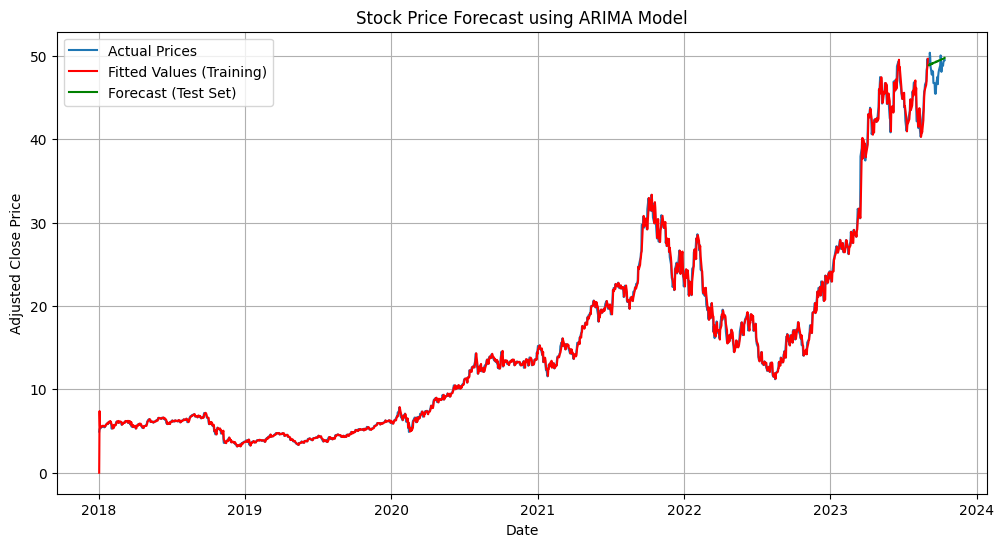

[*********************100%%**********************]  1 of 1 completed


Mean Squared Error (MSE): 10.4963
Mean Absolute Error (MAE): 2.8037


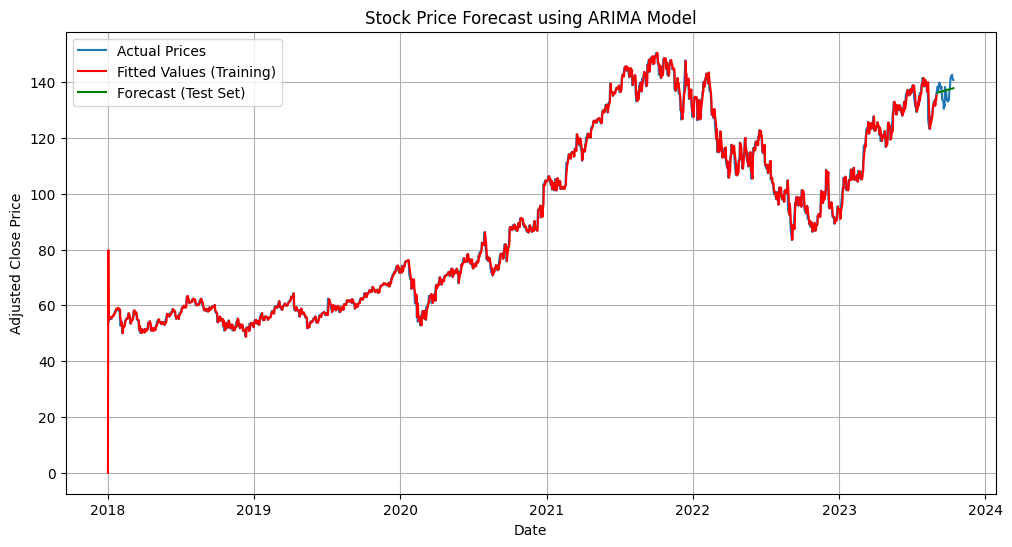

In [87]:
def arima_forecast_with_test(ticker_df, order=(1, 1, 1), test_size=30):
    """
    Perform ARIMA forecasting on stock data, using the last `test_size` days as a test set.
    
    Parameters:
    - ticker_df: DataFrame containing stock data with 'Adj Close' column.
    - order: Tuple specifying the (p, d, q) parameters for ARIMA model.
    - test_size: Number of days to reserve as test data.
    
    Returns:
    - forecast: Forecasted values for the test set.
    """

    # Select the target variable (e.g., 'Adj Close')
    data = ticker_df['Adj Close']
    
    # Ensure that the index has the correct frequency set
    data.index = pd.date_range(start=data.index[0], periods=len(data), freq='B')
    
    # Train-Test Split
    train_data = data[:-test_size]
    test_data = data[-test_size:]
    
    # Build and fit ARIMA model on training data
    model = ARIMA(train_data, order=order)
    arima_result = model.fit()
    
    # Make predictions for the test set
    forecast = arima_result.forecast(steps=test_size)
    
    # Metrics Evaluation (MAE, MSE) on the test set
    mse = mean_squared_error(test_data, forecast)
    mae = mean_absolute_error(test_data, forecast)
    
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    
    # Plot actual vs forecasted prices
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data, label='Actual Prices')
    plt.plot(train_data.index, arima_result.fittedvalues, color='red', label='Fitted Values (Training)')
    plt.plot(test_data.index, forecast, color='green', label='Forecast (Test Set)')
    plt.legend(loc='best')
    plt.title('Stock Price Forecast using ARIMA Model')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.grid(True)
    plt.show()

    return forecast

# Download NVDA stock data
nvda_ticker = yf.download("NVDA", start="2018-01-01", end="2024-01-01")
f_nvda = arima_forecast_with_test(nvda_ticker, (3, 2, 3))

# Download GOOG stock data
goog_ticker = yf.download("GOOG", start="2018-01-01", end="2024-01-01")
f_goog = arima_forecast_with_test(goog_ticker, (1, 2, 1))


### LSTM Forecasting with Test Set Validation

In this section, we implement LSTM forecasting on stock data for NVDA and GOOG, focusing on predicting the stock prices and forecasting the next 100 days. This approach helps us to both evaluate the model's performance on historical data and make predictions for future stock prices.

#### LSTM Model Overview

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) that is well-suited for time series forecasting. Unlike traditional RNNs, LSTMs are capable of learning long-term dependencies, making them particularly effective for time series data, where past events can influence future values.

The key features of an LSTM model include:

- **Memory Cells**: LSTMs use memory cells to store information for long periods, allowing the model to retain context and better understand the sequence of data.
- **Forget Gate**: This component decides which information to discard from the memory.
- **Input Gate**: This gate determines which new information to store in the memory.
- **Output Gate**: It decides what the next hidden state should be based on the memory cell.

#### Steps Involved in the Analysis

1. **Data Preparation**:
   - We download historical stock data for NVDA and GOOG from January 1, 2018, to January 1, 2024.
   - The data is scaled between 0 and 1 to make it suitable for the LSTM model. This step is crucial because LSTM models are sensitive to the scale of input data.
   - The data is then split into a training set (all data except the last 100 days) and a test set (which includes the last 60 days to provide context for the prediction).

2. **Model Training**:
   - An LSTM model is built with two LSTM layers and dropout layers to prevent overfitting. 
   - The model is trained on the training data, where it learns the underlying patterns in the stock prices.

3. **Prediction and Forecasting**:
   - The model generates predictions for the test set, which is then compared to the actual prices to evaluate the model's performance.
   - The model also forecasts the stock prices for the next 100 days beyond the available data.

4. **Performance Evaluation**:
   - Key performance metrics such as **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** are calculated to assess the accuracy of the model's predictions.
   - These metrics provide insight into how well the model captures the underlying trends in the stock prices.

5. **Visualization**:
   - The actual prices, predicted values, and forecasted values are plotted to visualize the model's performance.
   - This plot helps in understanding how closely the model's predictions and forecasts align with the actual stock prices.

#### Results and Interpretation

The model's effectiveness is evaluated based on its ability to accurately predict and forecast stock prices. By comparing the model's predictions with actual prices, we can gauge its accuracy and reliability. The future forecast provides a glimpse into how the model might perform in predicting stock prices for unseen data.


[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
43/43 [==============================] - 12s 55ms/step - loss: 0.0063
Epoch 2/50
43/43 [==============================] - 2s 50ms/step - loss: 0.0017
Epoch 3/50
43/43 [==============================] - 3s 76ms/step - loss: 0.0017
Epoch 4/50
43/43 [==============================] - 3s 59ms/step - loss: 0.0013
Epoch 5/50
43/43 [==============================] - 3s 58ms/step - loss: 0.0013
Epoch 6/50
43/43 [==============================] - 2s 57ms/step - loss: 0.0012
Epoch 7/50
43/43 [==============================] - 3s 64ms/step - loss: 0.0010
Epoch 8/50
43/43 [==============================] - 3s 60ms/step - loss: 0.0010
Epoch 9/50
43/43 [==============================] - 2s 54ms/step - loss: 9.3720e-04
Epoch 10/50
43/43 [==============================] - 2s 56ms/step - loss: 9.1947e-04
Epoch 11/50
43/43 [==============================] - 3s 72ms/step - loss: 0.0010
Epoch 12/50
43/43 [==============================] - 3s 66ms/step - loss: 8.5121e-04
Epoch 13/50
43/43 [=====

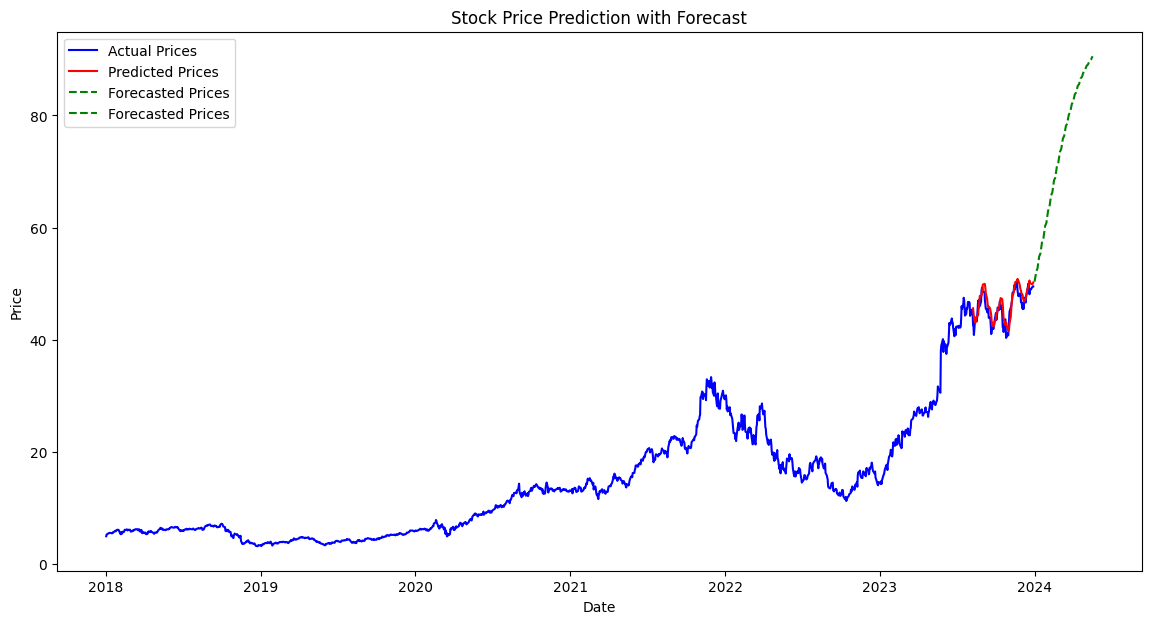

[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
43/43 [==============================] - 11s 46ms/step - loss: 0.0261
Epoch 2/50
43/43 [==============================] - 3s 59ms/step - loss: 0.0045
Epoch 3/50
43/43 [==============================] - 3s 63ms/step - loss: 0.0036
Epoch 4/50
43/43 [==============================] - 3s 65ms/step - loss: 0.0032
Epoch 5/50
43/43 [==============================] - 2s 54ms/step - loss: 0.0029
Epoch 6/50
43/43 [==============================] - 2s 52ms/step - loss: 0.0029
Epoch 7/50
43/43 [==============================] - 2s 48ms/step - loss: 0.0026
Epoch 8/50
43/43 [==============================] - 2s 49ms/step - loss: 0.0026
Epoch 9/50
43/43 [==============================] - 3s 63ms/step - loss: 0.0022
Epoch 10/50
43/43 [==============================] - 4s 92ms/step - loss: 0.0025
Epoch 11/50
43/43 [==============================] - 4s 92ms/step - loss: 0.0024
Epoch 12/50
43/43 [==============================] - 4s 79ms/step - loss: 0.0023
Epoch 13/50
43/43 [=================

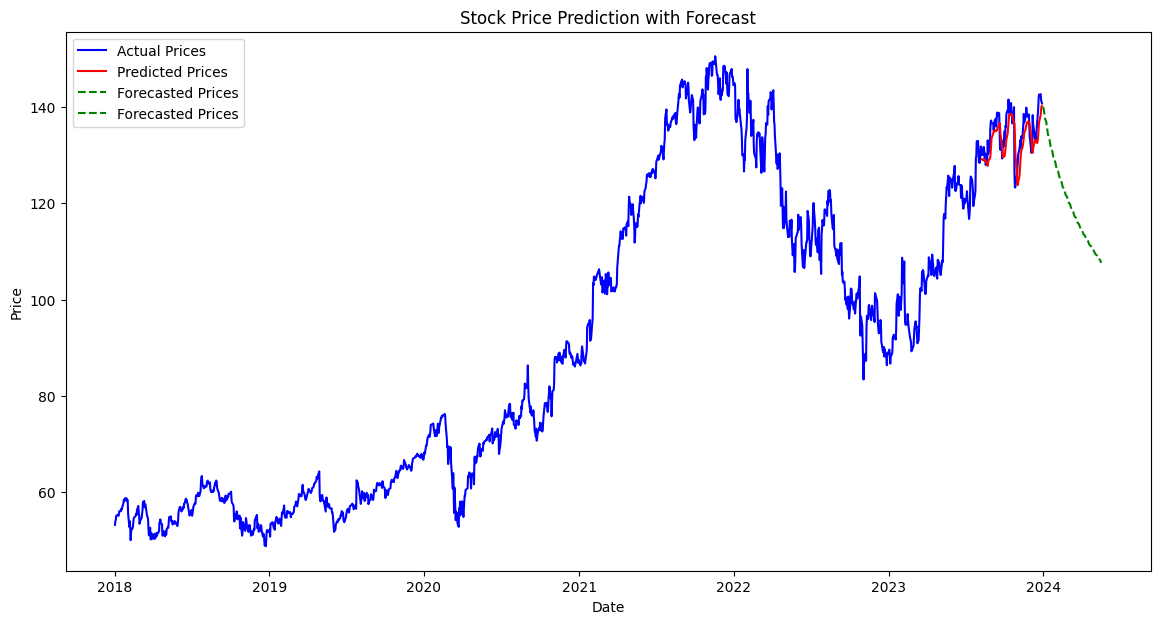

In [150]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

def lstm_forecast(ticker_data, forecast_days=100):
    
    set_seed()

    # Extract data
    data = ticker_data['Adj Close']
    
    # Step 2: Preprocess the Data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    # Define training data length (use all data except last 100 days)
    training_data_len = len(scaled_data) - forecast_days

    train_data = scaled_data[:training_data_len]
    test_data = scaled_data[training_data_len-60:]  # Include some previous days for context

    # Create the training datasets
    def create_dataset(data, time_step=60):
        X, y = [], []
        for i in range(time_step, len(data)):
            X.append(data[i-time_step:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_dataset(train_data)
    X_test, y_test = create_dataset(test_data)

    # Reshape the data to be 3D for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Step 3: Build the LSTM Model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Step 4: Train the Model
    model.fit(X_train, y_train, batch_size=32, epochs=50)

    # Step 5: Make Predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # Compute the Mean Squared Error and Mean Absolute Error
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    mse = mean_squared_error(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

    # Forecast Future Days
    last_sequence = scaled_data[-60:]  # Use the last 60 days for prediction
    forecast_inputs = last_sequence.reshape(1, -1, 1)
    
    future_predictions = []
    for _ in range(forecast_days):
        forecast = model.predict(forecast_inputs)
        future_predictions.append(forecast[0, 0])
        # Update forecast_inputs for the next step
        forecast_inputs = np.append(forecast_inputs[:, 1:, :], [[forecast[0]]], axis=1)

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

    # Step 6: Evaluate and Plot Results
    # Full data for plotting
    full_data = data.values
    dates = data.index

    # Define the dates for the last 100 days and future forecast days
    forecast_dates = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='B')  # Business days

    # Create a DataFrame for easy plotting
    plot_data = pd.DataFrame(index=dates)
    plot_data['Actual'] = np.nan
    plot_data['Predicted'] = np.nan
    plot_data['Forecast'] = np.nan

    # Fill in the actual data using .loc
    plot_data.loc[plot_data.index[:training_data_len], 'Actual'] = full_data[:training_data_len]
    plot_data.loc[plot_data.index[training_data_len:], 'Actual'] = full_data[training_data_len:]

    # Fill in the predicted data for the last 100 days using .loc
    plot_data.loc[plot_data.index[-len(predictions):], 'Predicted'] = predictions.flatten()

    # Fill in the forecast data for the future
    forecast_df = pd.DataFrame(index=forecast_dates)
    forecast_df['Forecast'] = future_predictions
    plot_data = pd.concat([plot_data, forecast_df], axis=1)

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(plot_data.index, plot_data['Actual'], color='blue', label='Actual Prices')
    plt.plot(plot_data.index, plot_data['Predicted'], color='red', label='Predicted Prices')
    plt.plot(plot_data.index, plot_data['Forecast'], color='green', linestyle='dashed', label='Forecasted Prices')
    plt.title('Stock Price Prediction with Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example usage
nvda_ticker = yf.download("NVDA", start="2018-01-01", end="2024-01-01")
lstm_forecast(nvda_ticker, forecast_days=100)

goog_ticker = yf.download("GOOG", start="2018-01-01", end="2024-01-01")
lstm_forecast(goog_ticker, forecast_days=100)